In [1]:
import pandas as pd
import numpy as np
import scipy.io
import math
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from collections import Counter
from matplotlib.colors import Normalize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
warnings.filterwarnings("ignore")
from tensorflow.keras.layers import Dense, Input
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
warnings.filterwarnings("ignore")
%matplotlib inline


In [42]:
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0] + 1)
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):

            pretty(value, indent + 2)
            print('-----------------------')
        else:
            print('\t' * (indent + 2) + str(value))
            print(" ")
def most_frequent(List):
    occurence_count = Counter(List)
    return occurence_count.most_common(1)[0][0]
def rms(arr):
    n = len(arr)
    squared = np.array(arr) * np.array(arr)
    sum = np.sum(squared)
    mean = (sum / (float)(n))
    root = math.sqrt(mean)
    return root
def mav(arr):
    n = len(arr)
    mav = sum((abs(np.array(arr))))/(float)(n)
    return mav
def var(arr):
    n = len(arr)
    squared = np.array(arr) * np.array(arr)
    sum = np.sum(squared)
    result = (sum / (float)(n))
    return result
def wl(arr):
    n = len(arr)
    sum = 0
    for i in range(1, n):
        sum += abs(arr[i] - arr[i - 1])
    return sum
def iav(arr):
    return sum(abs(np.array(arr)))
def extractSubject(name):
    ex1Path = 'DB1/' + name + '/' + name + '_A1_E1.mat'
    print(ex1Path)
    ex1 = scipy.io.loadmat(ex1Path)
    emg = ex1['emg']
    EMGdf = pd.DataFrame.from_dict(emg)
    stimulus = ex1['stimulus']

    ex2Path = 'DB1/' + name + '/' + name + '_A1_E2.mat'
    ex2 = scipy.io.loadmat(ex2Path)
    emg2 = ex2['emg']
    EMGdf2 = pd.DataFrame.from_dict(emg2)
    stimulus2 = ex2['stimulus']

    ex3Path = 'DB1/' + name + '/' + name + '_A1_E3.mat'
    ex3 = scipy.io.loadmat(ex3Path)
    emg3 = ex3['emg']
    EMGdf3 = pd.DataFrame.from_dict(emg3)
    stimulus3 = ex3['stimulus']

    Movements = {}
    for m in range(1, 53):
        if (m < 13):
            movementIndices = np.where(stimulus == m)[0]
            repetitions = consecutive(movementIndices)
            EMG = EMGdf
        elif (m < 30):
            movementIndices = np.where(stimulus2 == (m - 12))[0]
            repetitions = consecutive(movementIndices)
            EMG = EMGdf2
        else:
            movementIndices = np.where(stimulus3 == (m - 29))[0]
            repetitions = consecutive(movementIndices)
            EMG = EMGdf3

        Electrodes = {}
        for e in range(1, 11):
            temp = {}
            for r in range(1, 7):
                startIndex = repetitions[r - 1][0]
                LastIndex = repetitions[r - 1][len(repetitions[r - 1]) - 1]
                df = EMG.iloc[startIndex:LastIndex, e - 1]
                df.reset_index(drop=True, inplace=True)
                narray = df.to_numpy(dtype=None, copy=False)
                temp["R{0}".format(r)] = narray
            Electrodes["Electrode{0}".format(e)] = temp
        Movements["Movement{0}".format(m)] = Electrodes
    return Movements
def Average(lst):
    return sum(lst) / len(lst)


In [101]:
subjects_accuracy = pd.DataFrame(columns={'Accuracy', 'Accuracy_Modified'})
pca_window = []
pca_movement = []
final_df = pd.DataFrame(columns={
            # 'RMS1',
            # 'RMS2', 
            # 'RMS3', 
            # 'RMS4', 
            # 'RMS5', 
            # 'RMS6', 
            # 'RMS7', 
            # 'RMS8',
            # 'RMS9', 
            # 'RMS10',
                           'RMS1', 'MAV1', 'VAR1', 'WL1', 'IAV1',
                           'RMS2', 'MAV2', 'VAR2', 'WL2', 'IAV2',
                           'RMS3', 'MAV3', 'VAR3', 'WL3', 'IAV3',
                           'RMS4', 'MAV4', 'VAR4', 'WL4', 'IAV4',
                           'RMS5', 'MAV5', 'VAR5', 'WL5', 'IAV5',
                           'RMS6', 'MAV6', 'VAR6', 'WL6', 'IAV6',
                           'RMS7', 'MAV7', 'VAR7', 'WL7', 'IAV7',
                           'RMS8', 'MAV8', 'VAR8', 'WL8', 'IAV8',
                           'RMS9', 'MAV9', 'VAR9', 'WL9', 'IAV9',
                           'RMS10', 'MAV10', 'VAR10', 'WL10', 'IAV10',
                           'Train','Movement'})

for s in range(1,28):
    subject = 'S' + str(s)
    dff = pd.DataFrame.from_dict(extractSubject(subject))
    df = pd.DataFrame(columns={
            # 'RMS1',
            # 'RMS2', 
            # 'RMS3', 
            # 'RMS4', 
            # 'RMS5', 
            # 'RMS6', 
            # 'RMS7', 
            # 'RMS8',
            # 'RMS9', 
            # 'RMS10'
                                  'RMS1', 'MAV1', 'VAR1', 'WL1', 'IAV1',
                                  'RMS2', 'MAV2', 'VAR2', 'WL2', 'IAV2',
                                  'RMS3', 'MAV3', 'VAR3', 'WL3', 'IAV3',
                                  'RMS4', 'MAV4', 'VAR4', 'WL4', 'IAV4',
                                  'RMS5', 'MAV5', 'VAR5', 'WL5', 'IAV5',
                                  'RMS6', 'MAV6', 'VAR6', 'WL6', 'IAV6',
                                  'RMS7', 'MAV7', 'VAR7', 'WL7', 'IAV7',
                                  'RMS8', 'MAV8', 'VAR8', 'WL8', 'IAV8',
                                  'RMS9', 'MAV9', 'VAR9', 'WL9', 'IAV9',
                                  'RMS10', 'MAV10', 'VAR10', 'WL10', 'IAV10',
                                  'Train','Movement'})
    for e in range(1, 11):
        i = 0
        electrode = 'Electrode' + str(e)
        for m in range(1,53):
                M = dff['Movement'+str(m)][electrode]
                for r in range(1, 7):
                    rep = "R" + str(r)
                    if (r in [1, 3, 4, 6]):
                        train = 1
                    else:
                        train = 0
                    print(i)    
                    for x in range(0, len(M[rep]), 20):
                        df.at[i, 'RMS' + str(e)] = rms(M[rep][x:x + 50])
                        df.at[i, 'MAV' + str(e)] = mav(M[rep][x:x + 50])
                        df.at[i, 'VAR' + str(e)] = var(M[rep][x:x + 50])
                        df.at[i, 'WL' + str(e)] = wl(M[rep][x:x + 50])
                        df.at[i, 'IAV' + str(e)] = iav(M[rep][x:x + 50])
                        df.at[i, 'Movement'] = m
                        df.at[i, 'Train'] = train
                    
                        i += 1
                    print(i)    


    final_df = final_df.append(df, ignore_index=True)

DB1/S1/S1_A1_E1.mat
0
26
26
52
52
78
78
104
104
130
130
156
156
182
182
208
208
234
234
260
260
286
286
312
312
338
338
364
364
390
390
416
416
442
442
468
468
494
494
520
520
546
546
572
572
598
598
624
624
650
650
676
676
702
702
729
729
755
755
781
781
807
807
833
833
859
859
885
885
911
911
937
937
963
963
989
989
1015
1015
1041
1041
1067
1067
1093
1093
1119
1119
1145
1145
1171
1171
1197
1197
1223
1223
1249
1249
1275
1275
1301
1301
1327
1327
1353
1353
1379
1379
1405
1405
1431
1431
1457
1457
1483
1483
1509
1509
1535
1535
1561
1561
1587
1587
1613
1613
1639
1639
1665
1665
1691
1691
1717
1717
1743
1743
1769
1769
1795
1795
1821
1821
1847
1847
1873
1873
1899
1899
1925
1925
1951
1951
1977
1977
2003
2003
2029
2029
2055
2055
2081
2081
2107
2107
2133
2133
2159
2159
2185
2185
2211
2211
2237
2237
2263
2263
2289
2289
2315
2315
2341
2341
2367
2367
2393
2393
2419
2419
2445
2445
2471
2471
2497
2497
2523
2523
2549
2549
2575
2575
2601
2601
2627
2627
2653
2653
2679
2679
2705
2705
2731
2731
2757
2757


In [102]:
features = { 
    # 'RMS1','RMS2','RMS3','RMS3','RMS4','RMS5','RMS6','RMS7','RMS8','RMS9','RMS10'
            'RMS1', 'MAV1', 'VAR1', 'WL1', 'IAV1',
            'RMS2', 'MAV2', 'VAR2', 'WL2', 'IAV2',
            'RMS3', 'MAV3', 'VAR3', 'WL3', 'IAV3',
            'RMS4', 'MAV4', 'VAR4', 'WL4', 'IAV4',
            'RMS5', 'MAV5', 'VAR5', 'WL5', 'IAV5',
            'RMS6', 'MAV6', 'VAR6', 'WL6', 'IAV6',
            'RMS7', 'MAV7', 'VAR7', 'WL7', 'IAV7',
            'RMS8', 'MAV8', 'VAR8', 'WL8', 'IAV8',
            'RMS9', 'MAV9', 'VAR9', 'WL9', 'IAV9',
            'RMS10', 'MAV10', 'VAR10', 'WL10', 'IAV10',
            }

X_train = final_df[final_df['Train'] == 1].loc[:, features]
# scalar =  StandardScaler()
# scalar = scalar.fit(X_train)
# X_train = scalar.transform(X_train)
X_test = final_df[final_df['Train'] == 0].loc[:, features]
# X_test = scalar.transform(X_test)

y_train = final_df[final_df['Train'] == 1].loc[:, 'Movement']
y_test = final_df[final_df['Train'] == 0].loc[:, 'Movement']

y_train = np.asarray(y_train).astype('float64')
y_test = np.asarray(y_test).astype('float64')
X_train = np.asarray(X_train).astype('float64')




In [86]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# lda = LDA()
# X_train = lda.fit_transform(X_train, y_train)
# X_test = lda.transform(X_test)
# y_pred = lda.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(accuracy)
# y_test_new = [most_frequent(y_test[x:x + 26]) for x in range(0, len(y_test), 26)]
# y_predicted_new = [most_frequent(y_pred[x:x + 26]) for x in range(0, len(y_pred), 26)]
# accuracy_modified = accuracy_score(y_test_new, y_predicted_new)
# print(accuracy_modified)


0.04082888797702093
0.0472972972972973


In [98]:
y_train = np.asarray(y_train).astype('float64')
y_test = np.asarray(y_test).astype('float64')
X_train = np.asarray(X_train).astype('float64')

acc = []
for n in range (2,16):
    clf = KNeighborsClassifier(n_neighbors=n)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    y_test_new = [most_frequent(y_test[x:x + 26]) for x in range(0, len(y_test), 26)]
    y_predicted_new = [most_frequent(y_pred[x:x + 26]) for x in range(0, len(y_pred), 26)]
    accuracy_modified = accuracy_score(y_test_new, y_predicted_new)
    print(accuracy_modified)
    acc.append(accuracy_modified)   

0.7592460881934566
0.7660028449502134
0.7716927453769559
0.7724039829302988
0.7716927453769559
0.7706258890469416
0.7752489331436699
0.7660028449502134
0.7642247510668563
0.7613798008534851
0.7603129445234709
0.7539118065433855
0.7542674253200569
0.7464438122332859


In [81]:
# acc = [0.8890469416785206,0.8374822190611664, 0.8556187766714083, 0.854551920341394, 0.8556187766714083,
# 0.8495732574679943, 0.8524182076813656, 0.8492176386913229, 0.8463726884779517, 0.8378378378378378, 
# 0.8421052631578947, 0.8342816500711238, 0.833570412517781, 0.8289473684210527, 0.8243243243243243]

# x = final_df.loc[:, features]
# y = final_df.loc[:,['Movement']].values
# y = y.astype('int')
# x = StandardScaler().fit_transform(x)
# pcas = []
# for p in range(5,51):
#     pca = PCA(n_components=p)
#     principalComponents = pca.fit_transform(x)
#     principalDf = pd.DataFrame(data=principalComponents)
#     finalDf = pd.concat([principalDf, final_df['Movement'], final_df['Train']], axis=1)

#     X_train = finalDf[finalDf['Train'] == 1]
#     X_train.drop({'Movement', 'Train'}, axis=1, inplace=True)
#     X_test = finalDf[finalDf['Train'] == 0]
#     X_test.drop({'Movement', 'Train'}, axis=1, inplace=True)
#     y_train = finalDf[finalDf['Train'] == 1]['Movement'].astype('int')
#     y_test = finalDf[finalDf['Train'] == 0]['Movement'].astype('int')

#     clf = RandomForestClassifier()
#     clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     y_test_new = [most_frequent(y_test[x:x + 26]) for x in range(0, len(y_test), 26)]
#     y_predicted_new = [most_frequent(y_pred[x:x + 26]) for x in range(0, len(y_pred), 26)]
#     accuracy_modified = accuracy_score(y_test_new, y_predicted_new)

#     print("PCA", p)
#     print("Movement Accuracy", accuracy_modified)
#     pcas.append(accuracy_modified)

PCA 5
Movement Accuracy 0.5433854907539118
PCA 6
Movement Accuracy 0.6774537695590327
PCA 7
Movement Accuracy 0.748221906116643
PCA 8
Movement Accuracy 0.7887624466571835
PCA 9
Movement Accuracy 0.8115220483641536
PCA 10
Movement Accuracy 0.8303698435277382
PCA 11
Movement Accuracy 0.8474395448079659
PCA 12
Movement Accuracy 0.844950213371266
PCA 13
Movement Accuracy 0.8541963015647226
PCA 14
Movement Accuracy 0.8549075391180654
PCA 15
Movement Accuracy 0.8552631578947368
PCA 16
Movement Accuracy 0.8613086770981507
PCA 17
Movement Accuracy 0.8566856330014224
PCA 18
Movement Accuracy 0.8627311522048364
PCA 19
Movement Accuracy 0.8627311522048364
PCA 20
Movement Accuracy 0.8680654338549075
PCA 21
Movement Accuracy 0.8620199146514936
PCA 22
Movement Accuracy 0.866642958748222
PCA 23
Movement Accuracy 0.8673541963015647
PCA 24
Movement Accuracy 0.8673541963015647
PCA 25
Movement Accuracy 0.8662873399715505
PCA 26
Movement Accuracy 0.8716216216216216
PCA 27
Movement Accuracy 0.8701991465149

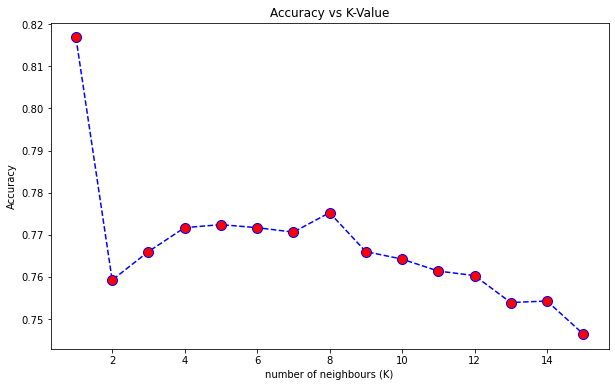

In [99]:

plt.figure(figsize=(10,6))
plt.plot(range(1,16),acc,color='blue', linestyle='dashed',marker='o',markerfacecolor='red', markersize=10)
plt.title('Accuracy vs K-Value')
plt.xlabel('number of neighbours (K)')
plt.ylabel('Accuracy')
plt.show()

In [103]:

from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
y_test_new = [most_frequent(y_test[x:x + 26]) for x in range(0, len(y_test), 26)]
y_predicted_new = [most_frequent(y_pred[x:x + 26]) for x in range(0, len(y_pred), 26)]
accuracy_modified = accuracy_score(y_test_new, y_predicted_new)

print("Window Accuracy",accuracy)
print("Movement Accuracy", accuracy_modified)

# # print("Y_Train" , y_train.shape)
# # print("Y_Test" , y_test.shape)
# # print("X_Train" , X_train.shape)
# # print("X_Test" , X_test.shape)

# # y_train = np.asarray(y_train).astype('float64')
# # y_test = np.asarray(y_test).astype('float64')
# # X_train = np.asarray(X_train).astype('float64')

# # y_train = tf.one_hot(y_train, 50)
# # y_test = tf.one_hot(y_test, 50)
# # print("Ba3d l 7adsa")
# # print("Y_Train" , y_train.shape)
# # input = Input(shape =(50,))
# # x = Dense(512, activation='relu')(input)
# # x = Dense(256, activation='relu')(x)  
# # x = Dense(256, activation='relu')(x)
# # ouput = Dense(50, activation='softmax')(x)
# # model = Model(input, ouput)
# # model.compile(optimizer=Adam(learning_rate=0.005), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
# # model.fit(X_train, y_train, epochs=100)
# # print(model.evaluate(X_test, y_test))
# # predicted = model.predict(X_test)



In [52]:
# subjects_accuracy = pd.DataFrame(columns={'Accuracy_Modified'})
# sub = []
# pca_movement = []

# for s in range(1,28):
#     subject = 'S' + str(s)
#     dff_sub = pd.DataFrame.from_dict(extractSubject(subject))
#     df_sub = pd.DataFrame(columns={'RMS1', 'MAV1', 'VAR1', 'WL1', 'IAV1',
#                                   'RMS2', 'MAV2', 'VAR2', 'WL2', 'IAV2',
#                                   'RMS3', 'MAV3', 'VAR3', 'WL3', 'IAV3',
#                                   'RMS4', 'MAV4', 'VAR4', 'WL4', 'IAV4',
#                                   'RMS5', 'MAV5', 'VAR5', 'WL5', 'IAV5',
#                                   'RMS6', 'MAV6', 'VAR6', 'WL6', 'IAV6',
#                                   'RMS7', 'MAV7', 'VAR7', 'WL7', 'IAV7',
#                                   'RMS8', 'MAV8', 'VAR8', 'WL8', 'IAV8',
#                                   'RMS9', 'MAV9', 'VAR9', 'WL9', 'IAV9',
#                                   'RMS10', 'MAV10', 'VAR10', 'WL10', 'IAV10',
#                                   'Train','Movement'})
#     for e in range(1, 11):
#         i = 0
#         electrode = 'Electrode' + str(e)
#         for m in range(1,53):
#                 M = dff_sub['Movement'+str(m)][electrode]
#                 for r in range(1, 7):
#                     rep = "R" + str(r)
#                     if (r in [1, 3, 4, 6]):
#                         train = 1
#                     else:
#                         train = 0
            
#                     for x in range(0, len(M[rep]), 20):
#                         df_sub.at[i, 'RMS' + str(e)] = rms(M[rep][x:x + 50])
#                         df_sub.at[i, 'MAV' + str(e)] = mav(M[rep][x:x + 50])
#                         df_sub.at[i, 'VAR' + str(e)] = var(M[rep][x:x + 50])
#                         df_sub.at[i, 'WL' + str(e)] = wl(M[rep][x:x + 50])
#                         df_sub.at[i, 'IAV' + str(e)] = iav(M[rep][x:x + 50])
#                         df_sub.at[i, 'Movement'] = m
#                         df_sub.at[i, 'Train'] = train
                    
#                         i += 1
                    
#     features = { 
#             'RMS1', 'MAV1', 'VAR1', 'WL1', 'IAV1',
#             'RMS2', 'MAV2', 'VAR2', 'WL2', 'IAV2',
#             'RMS3', 'MAV3', 'VAR3', 'WL3', 'IAV3',
#             'RMS4', 'MAV4', 'VAR4', 'WL4', 'IAV4',
#             'RMS5', 'MAV5', 'VAR5', 'WL5', 'IAV5',
#             'RMS6', 'MAV6', 'VAR6', 'WL6', 'IAV6',
#             'RMS7', 'MAV7', 'VAR7', 'WL7', 'IAV7',
#             'RMS8', 'MAV8', 'VAR8', 'WL8', 'IAV8',
#             'RMS9', 'MAV9', 'VAR9', 'WL9', 'IAV9',
#             'RMS10', 'MAV10', 'VAR10', 'WL10', 'IAV10',
#     }

#     X_train = df_sub[df_sub['Train'] == 1].loc[:, features]
#     scalar =  StandardScaler()
#     scalar = scalar.fit(X_train)
#     X_train = scalar.transform(X_train)
#     X_test = df_sub[df_sub['Train'] == 0].loc[:, features]
#     X_test = scalar.transform(X_test)
#     y_train = df_sub[df_sub['Train'] == 1].loc[:, 'Movement']
#     y_test = df_sub[df_sub['Train'] == 0].loc[:, 'Movement']

#     y_train = np.asarray(y_train).astype('float64')
#     y_test = np.asarray(y_test).astype('float64')
#     X_train = np.asarray(X_train).astype('float64')

#     clf = RandomForestClassifier()
#     clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     y_test_new = [most_frequent(y_test[x:x + 11]) for x in range(0, len(y_test), 11)]
#     y_predicted_new = [most_frequent(y_pred[x:x + 11]) for x in range(0, len(y_pred), 11)]
#     accuracy_modified = accuracy_score(y_test_new, y_predicted_new)

#     print("Window Accuracy",accuracy)
#     print("Movement Accuracy", accuracy_modified)
#     sub.append(accuracy_modified)

DB1/S1/S1_A1_E1.mat
Window Accuracy 0.6512744735869966
Movement Accuracy 0.8866396761133604
DB1/S2/S2_A1_E1.mat
Window Accuracy 0.527890653860362
Movement Accuracy 0.7368421052631579
DB1/S3/S3_A1_E1.mat
Window Accuracy 0.5484467455621301
Movement Accuracy 0.7967479674796748
DB1/S4/S4_A1_E1.mat
Window Accuracy 0.5207100591715976
Movement Accuracy 0.7357723577235772
DB1/S5/S5_A1_E1.mat
Window Accuracy 0.613905325443787
Movement Accuracy 0.8373983739837398
DB1/S6/S6_A1_E1.mat
Window Accuracy 0.56789224608664
Movement Accuracy 0.804
DB1/S7/S7_A1_E1.mat
Window Accuracy 0.7034023668639053
Movement Accuracy 0.8536585365853658
DB1/S8/S8_A1_E1.mat
Window Accuracy 0.6335059171597633
Movement Accuracy 0.8252032520325203
DB1/S9/S9_A1_E1.mat
Window Accuracy 0.6564349112426036
Movement Accuracy 0.8455284552845529
DB1/S10/S10_A1_E1.mat
Window Accuracy 0.6220414201183432
Movement Accuracy 0.8577235772357723
DB1/S11/S11_A1_E1.mat
Window Accuracy 0.6612426035502958
Movement Accuracy 0.8252032520325203
D

[0.89 0.74 0.8  0.74 0.84 0.8  0.85 0.83 0.85 0.86 0.83 0.86 0.73 0.76
 0.64 0.72 0.75 0.67 0.74 0.86 0.89 0.89 0.74 0.78 0.86 0.83 0.8 ]


ValueError: The number of FixedLocator locations (27), usually from a call to set_ticks, does not match the number of ticklabels (26).

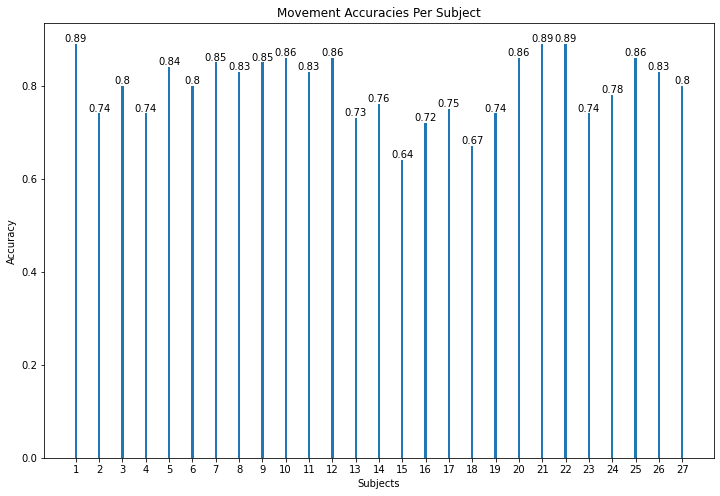

In [75]:

# sub = np.around(sub, decimals=2)
# print(sub)
# subjects_label = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10',
#             'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19',
#             'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27']
# x =  range(1,28)  # the label locations
# width = 0.1  # the width of the bars
# fig, ax = plt.subplots(figsize=(12, 8))
# movement = ax.bar(x, sub, width, label='Movement Accuracy')

# ax.set_ylabel('Accuracy')
# ax.set_xlabel('Subjects')
# ax.set_title('Movement Accuracies Per Subject')
# ax.bar_label(movement)
# # ax.set_xticks(subjects, subjects)
# ax.set_xticks(x, subjects_label)
# ax.legend()
# ax.bar_label(movement)
# fig.tight_layout()
# plt.show()

In [ ]:

# pcas = []
# x = final_df.loc[:, features]
# y = final_df.loc[:,['Movement']].values
# y=y.astype('int')
# x = StandardScaler().fit_transform(x)
# for p in range(5,51):
#     pca = PCA(n_components=p)
#     principalComponents = pca.fit_transform(x)
#     principalDf = pd.DataFrame(data=principalComponents)
#     finalDf = pd.concat([principalDf, final_df['Movement'], final_df['Train']], axis=1)

#     X_train = finalDf[finalDf['Train'] == 1]
#     X_train.drop({'Movement', 'Train'}, axis=1, inplace=True)
#     X_test = finalDf[finalDf['Train'] == 0]
#     X_test.drop({'Movement', 'Train'}, axis=1, inplace=True)
#     y_train = finalDf[finalDf['Train'] == 1]['Movement'].astype('int')
#     y_test = finalDf[finalDf['Train'] == 0]['Movement'].astype('int')

#     clf = RandomForestClassifier()
#     clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     y_test_new = [most_frequent(y_test[x:x + 11]) for x in range(0, len(y_test), 11)]
#     y_predicted_new = [most_frequent(y_pred[x:x + 11]) for x in range(0, len(y_pred), 11)]
#     accuracy_modified = accuracy_score(y_test_new, y_predicted_new)

#     print("Window Accuracy",accuracy)
#     print("Movement Accuracy", accuracy_modified)
#     pcas.append(accuracy_modified)

tf.Tensor(
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.], shape=(50,), dtype=float32)
[6.22559497e-08 2.52733435e-02 3.00039016e-02 2.61483416e-02
 1.89811178e-02 2.17039976e-02 2.08186656e-02 2.33653169e-02
 2.71557402e-02 2.29848828e-02 3.01359836e-02 1.90238338e-02
 2.05076728e-02 1.13982176e-02 2.13716403e-02 1.81448739e-02
 6.92596333e-03 2.92308312e-02 2.34018527e-02 2.07329728e-02
 2.34837700e-02 1.99910887e-02 2.34945659e-02 2.47931201e-02
 1.43656405e-02 1.33768311e-02 1.99216586e-02 5.73136937e-03
 2.27423906e-02 1.56588331e-02 1.77109037e-02 7.82484468e-03
 1.97790451e-02 1.94790494e-02 2.82972883e-02 2.40613241e-02
 2.67190374e-02 1.39267435e-02 1.89154223e-02 2.42363475e-02
 2.41824817e-02 2.83982474e-02 2.85691060e-02 2.89683435e-02
 2.56955866e-02 2.54868027e-02 2.25997344e-02 2.53125769e-03
 9.43093840e-03 2.31904676e-03]
